<a href="https://colab.research.google.com/github/Elwing-Chou/tibaml0606/blob/main/transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import zipfile
path = "/content/drive/MyDrive/additional/train.zip"
f = zipfile.ZipFile(path)
f.extractall()

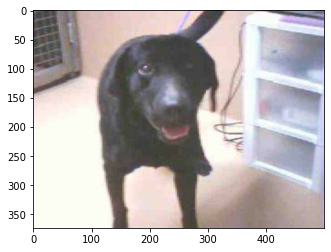

In [22]:
import glob
import matplotlib.pyplot as plt
from PIL import Image
fs = glob.glob("train/*")
plt.imshow(Image.open(fs[20]))

In [23]:
import random
import pandas as pd
dogs = glob.glob("train/dog.*")
random.shuffle(dogs)
cats = glob.glob("train/cat.*")
random.shuffle(cats)
train = pd.DataFrame({
    "path":dogs[:900] + cats[:900],
    "target":[0] * 900 + [1] * 900
})
validate = pd.DataFrame({
    "path":dogs[900:950] + cats[900:950],
    "target":[0] * 50 + [1] * 50
})
test = pd.DataFrame({
    "path":dogs[950:1000] + cats[950:1000],
    "target":[0] * 50 + [1] * 50
})

In [24]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import BatchNormalization
for l in vgg.layers:
    l.trainable = False
layers = [
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(2, activation="softmax")
]
layers = vgg.layers + layers
model = Sequential(layers)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [26]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
       optimizer="adam",
       metrics=["accuracy"])

In [27]:
import numpy as np

In [28]:
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
fs = glob.glob("train/*")
target = fs[20]

# 預處理(要照你偷來的模型做)
from tensorflow.keras.applications.vgg16 import preprocess_input
img = Image.open(target).resize((224, 224)).convert("RGB")
img_np = preprocess_input(np.array(img))
print(img_np)

[[[-31.939003  -25.779     -35.68     ]
  [-28.939003  -23.779     -33.68     ]
  [-21.939003  -18.779     -28.68     ]
  ...
  [ 46.060997   -3.7789993 -14.68     ]
  [ 44.060997   -4.7789993 -15.68     ]
  [ 44.060997   -3.7789993 -14.68     ]]

 [[ -6.939003   -2.7789993 -12.68     ]
  [ -2.939003   -0.7789993  -9.68     ]
  [ -3.939003   -3.7789993 -12.68     ]
  ...
  [ 40.060997   -6.7789993 -17.68     ]
  [ 37.060997   -9.778999  -20.68     ]
  [ 35.060997   -9.778999  -21.68     ]]

 [[  2.060997   -0.7789993  -9.68     ]
  [ -5.939003   -9.778999  -17.68     ]
  [-18.939003  -23.779     -32.68     ]
  ...
  [ 36.060997   -8.778999  -18.68     ]
  [ 38.060997   -5.7789993 -15.68     ]
  [ 38.060997   -5.7789993 -15.68     ]]

 ...

 [[139.061     137.22101   128.32     ]
  [139.061     137.22101   128.32     ]
  [139.061     137.22101   128.32     ]
  ...
  [ 64.061      47.221      59.32     ]
  [ 83.061      45.221      60.32     ]
  [ 89.061      47.221      63.32     ]]

 [

In [29]:
import numpy as np
x_train = np.array(train["path"])
y_train = np.array(train["target"])
x_validate = np.array(validate["path"])
y_validate = np.array(validate["target"])
x_test = np.array(test["path"])
y_test = np.array(test["target"])

In [30]:
from PIL import Image
from tensorflow.keras.applications.vgg16 import preprocess_input
def get_data(x, y, batch=None):
    # 如果不是None, 那代表是數字(20), 隨機20個idx
    # 如果是None, 那就沒有隨機, 拿全部
    if batch is not None:
        idx = np.random.randint(0, len(x), size=batch)
        x, y = x[idx], y[idx]
    # img_pre: preprocess過後的圖片
    # img_ori: 沒有preprocess的圖片
    img_pre, img_ori = [], []
    # 走過我的每一個path
    for p in x:
        # 讀取圖片並且預處理
        img = Image.open(p).convert("RGB").resize((224, 224))
        img = np.array(img)
        img_pre.append(preprocess_input(img))
        img_ori.append(img)
    # 回傳(預處理過後圖片, 沒處理圖片, 答案)
    return (np.array(img_pre), np.array(img_ori), y)
# 使用範例
x, x_ori, y = get_data(x_train, y_train, 10)
print(x.shape)
print(x_ori.shape)
print(y.shape)
# print(x)

(10, 224, 224, 3)
(10, 224, 224, 3)
(10,)


In [31]:
# validate和test全部讀出來
xv, xv_ori, yv = get_data(x_validate, y_validate)
xt, xt_ori, yt = get_data(x_test, y_test)
print(xv.shape)
print(xt.shape)

(100, 224, 224, 3)
(100, 224, 224, 3)


In [32]:
# 我沒有使用fit: 因為使用fit你一定要把全部圖都讀好(現實世界不太可能)
# 真的自己一步一步來: train_on_batch, test_on_batch
for i in range(50):
    x, _, y = get_data(x_train, y_train, batch=20)
    result = model.train_on_batch(x, y)
    print("train:", result)
    result = model.test_on_batch(xv, yv)
    print("validate:", result)
    print("-" * 15, i, "end", "-" * 15)

train: [0.829748809337616, 0.30000001192092896]
validate: [1.9715667963027954, 0.44999998807907104]
--------------- 0 end ---------------
train: [0.7598591446876526, 0.4000000059604645]
validate: [1.3838777542114258, 0.5]
--------------- 1 end ---------------
train: [0.7987591028213501, 0.5]
validate: [1.1867904663085938, 0.5299999713897705]
--------------- 2 end ---------------
train: [0.8375908732414246, 0.44999998807907104]
validate: [1.0409785509109497, 0.5600000023841858]
--------------- 3 end ---------------
train: [0.7697035670280457, 0.3499999940395355]
validate: [0.9229437112808228, 0.5600000023841858]
--------------- 4 end ---------------
train: [0.6811519861221313, 0.6000000238418579]
validate: [0.8344977498054504, 0.5899999737739563]
--------------- 5 end ---------------
train: [0.6344491243362427, 0.6499999761581421]
validate: [0.7523055076599121, 0.6000000238418579]
--------------- 6 end ---------------
train: [0.776412844657898, 0.3499999940395355]
validate: [0.689669966

In [33]:
model.predict(x)

array([[0.39493832, 0.6050617 ],
       [0.9439822 , 0.05601786],
       [0.24373554, 0.75626445],
       [0.80772704, 0.19227293],
       [0.05307329, 0.9469267 ],
       [0.1504084 , 0.84959155],
       [0.04778204, 0.952218  ],
       [0.7076377 , 0.2923622 ],
       [0.9866541 , 0.01334593],
       [0.15062006, 0.84937996],
       [0.43399087, 0.56600916],
       [0.86950225, 0.13049771],
       [0.8942959 , 0.10570411],
       [0.15688072, 0.8431192 ],
       [0.9949517 , 0.00504833],
       [0.9050735 , 0.09492649],
       [0.9381199 , 0.06188017],
       [0.476906  , 0.523094  ],
       [0.19188975, 0.80811024],
       [0.9622669 , 0.03773313]], dtype=float32)